In [1]:
import sys
sys.path.append('../src')
from preamble import *
figure_path = os.path.join(root_dir,'reports','figures')

# get data files
files_dict = walk_directory(raw_data)
drews_data = list(files_dict.keys())
drews_data.remove('pump')
#drews_data.remove('Andrew_sleep') # not tracked

Andrew_nursing /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_nursing.csv
Andrew_sleep /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_sleep.csv
Andrew_diaper /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_diaper.csv
Andrew_temperature /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_temperature.csv
pump /home/jgalloway/github/andrews_baby_tracker/data/raw/pump.csv
Andrew_formula /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_formula.csv
wtageinf /home/jgalloway/github/andrews_baby_tracker/data/raw/wtageinf.csv
Andrew_other_activity /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_other_activity.csv
Andrew_growth /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_growth.csv
Andrew_milestone /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_milestone.csv
Andrew_expressed /home/jgalloway/github/andrews_baby_tracker/data/raw/Andrew_expressed.csv


CDC Data for weight [here](https://www.cdc.gov/growthcharts/percentile_data_files.htm)

In [2]:
from datetime import timedelta,datetime
def get_data(filename):
    return (pd.read_csv(filename)
             .drop(columns=['Baby'])
             .assign(Time= lambda x: pd.to_datetime(x.Time))
             .set_index('Time',drop=True))

def get_days_between(datePast, dateFuture):
   difference = dateFuture - datePast
   return difference.total_seconds() / timedelta(days=1).total_seconds()

In [3]:
# set date range for recent analysis
to_analyze = timedelta(days=7)
today = datetime.combine(datetime.now().date(), datetime.min.time())

def get_recent_filter(df):
    start_date = (df.index[-1] - to_analyze)
    analysis_flt = df.index > start_date
    return start_date,analysis_flt

## Diaper Habits

In [4]:
diaper_df = get_data(files_dict['Andrew_diaper'])
used_diaper_df = diaper_df.assign(used_diapers = 1).resample('1D').sum()['used_diapers']
# find diapers per day
print('Diapers per Day')
display(used_diaper_df.loc[used_diaper_df.index[-1]-pd.to_timedelta('14D'):].describe())
# mark daily habits
diaper_df['hour_of_day'] = [x.hour for x in diaper_df.index]
diaper_df = pd.concat((diaper_df,pd.get_dummies(diaper_df.Status)),axis=1)
diaper_df.Dirty = diaper_df.Dirty | diaper_df.Mixed
diaper_df.Wet = diaper_df.Wet | diaper_df.Mixed
diaper_df.drop(columns=['Dry','Mixed','Note'],inplace=True)

start_date,analysis_flt = get_recent_filter(diaper_df)

Diapers per Day


count    15.000000
mean      8.000000
std       2.035401
min       3.000000
25%       7.500000
50%       8.000000
75%       9.000000
max      12.000000
Name: used_diapers, dtype: float64

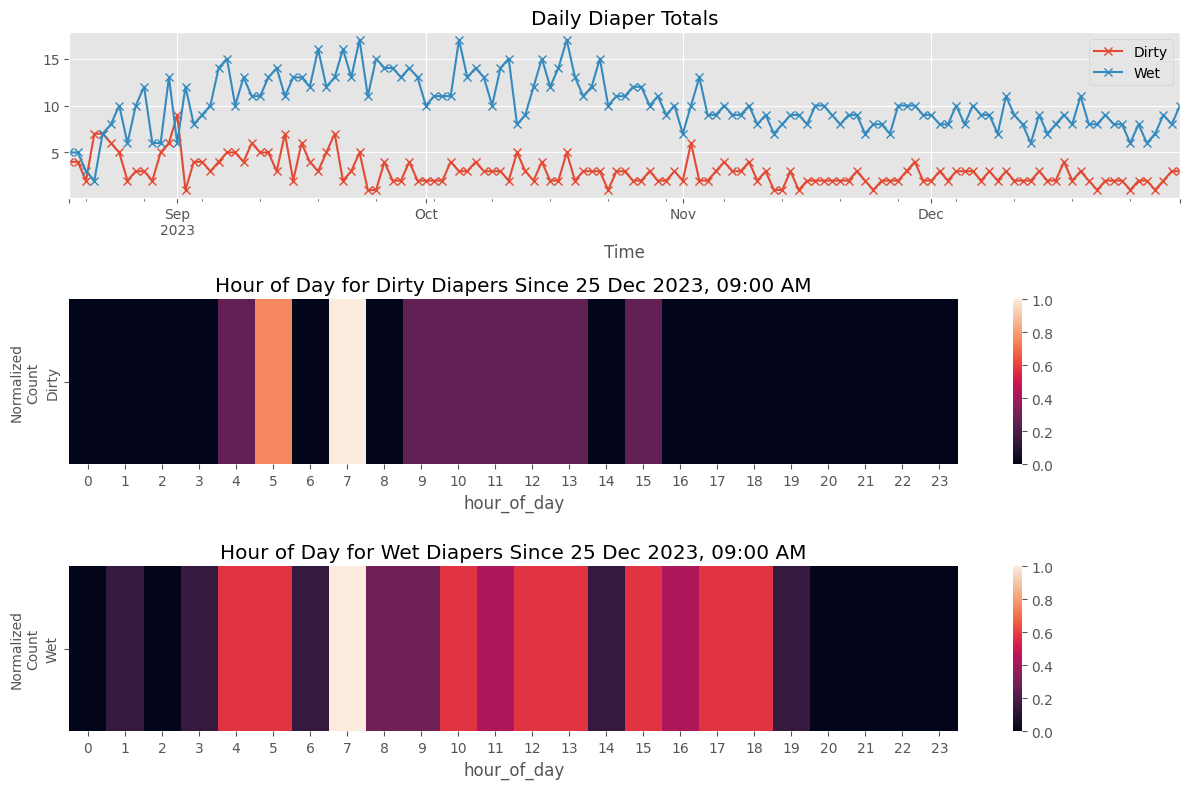

In [5]:
f,axes = plt.subplots(nrows=3,ncols=1,figsize=(12,8))
axes = axes.ravel()
ax = diaper_df[['Dirty','Wet']].resample('D').sum().iloc[:-1].plot(marker='x',ax=axes[0])
ax.set_title('Daily Diaper Totals')
tdf = (diaper_df.loc[analysis_flt]
       .drop(columns='Status')
       .groupby('hour_of_day')
       .sum()
       .reindex(list(range(0,24)),fill_value=0))
tdf = tdf/tdf.abs().max()

for ax,col in zip(axes[1:],['Dirty','Wet']):
    ax = sns.heatmap(data=tdf[[col]].transpose(),vmin=0,vmax=1,ax=ax)
    ax.set_ylabel('Normalized\nCount',fontsize=10)
    s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
    ax.set_title(f'Hour of Day for {col} Diapers Since {s}')
plt.tight_layout()
plt.savefig(os.path.join(figure_path,'diapers.png'),bbox_inches='tight')

## Weight

In [6]:
import statsmodels.api as sm

growth_df = get_data(files_dict['Andrew_growth'])
growth_df['days'] = [get_days_between(growth_df.index[0],x) for x in growth_df.index]
growth_df['sq_days'] = growth_df['days']*growth_df['days']
started_eating_filter = growth_df.days>2
model = sm.OLS(growth_df[started_eating_filter]['Weight (lbs.)'].values,
             sm.add_constant(growth_df[started_eating_filter][['days']].values))
res = model.fit()
display(res.summary())
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]
growth_df['pred'] = np.append(np.full(sum(~started_eating_filter), fill_value=np.nan),res.fittedvalues)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     774.6
Date:                Mon, 01 Jan 2024   Prob (F-statistic):           7.30e-17
Time:                        09:14:08   Log-Likelihood:                 3.8520
No. Observations:                  21   AIC:                            -3.704
Df Residuals:                      19   BIC:                            -1.615
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8947      0.068     42.763      0.000       2.753       3.036
x1             0.0320      0.001     27.832      0.000       0.030       0.034
==============================================================================
Omnibus:                        1.574   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.455   Jarque-Bera (JB):                1.250
Skew:                           0.409   Prob(JB):                        0.535
Kurtosis:                       2.128   Cond. No.                         86.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

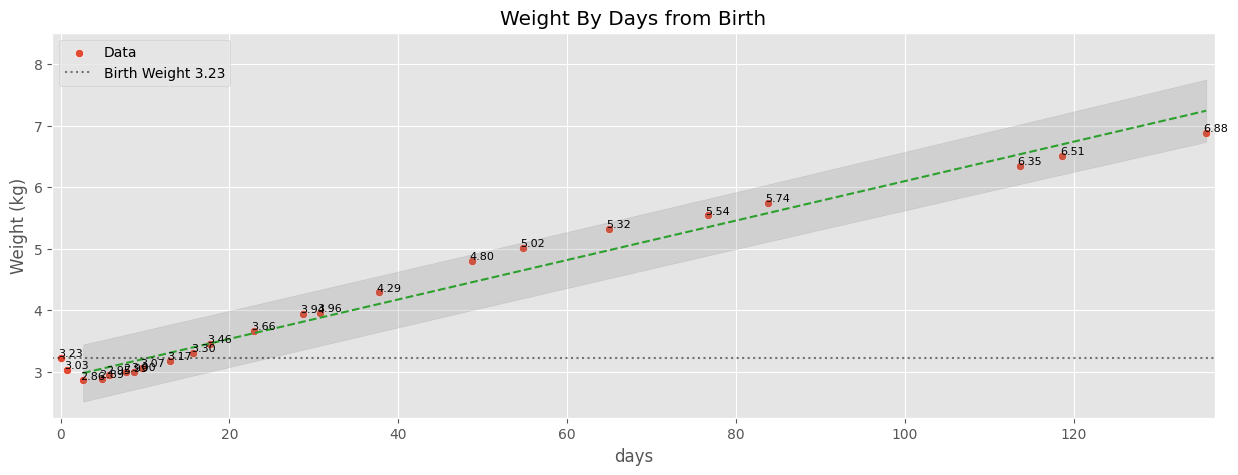

In [7]:
birth_weight = growth_df.at[growth_df.index[0],'Weight (lbs.)']
ax = sns.scatterplot(data=growth_df,x='days',y='Weight (lbs.)',label='Data')
ax = sns.lineplot(data=growth_df[started_eating_filter],x='days',y='pred',color='tab:green',
                  linestyle='dashed',label='_no_label_')
ax.axhline(birth_weight,label=f'Birth Weight {birth_weight:0.2f}',color='k',linestyle='dotted',alpha=0.5)
ax.fill_between(growth_df[started_eating_filter].days,
    iv_l, iv_u, color='tab:gray', alpha=0.2)

return_to_birth_weight = np.min(np.roots(np.poly1d([res.params[1],res.params[0] - birth_weight])))
r2bw_date = growth_df.index[0] + timedelta(days=return_to_birth_weight)
r2bw_date = datetime.strftime(r2bw_date,'%d %b %Y, %I:%M %p')
#ax.axvline(return_to_birth_weight,label = f'{return_to_birth_weight:0.2f} days',color='y',linestyle='dotted')
ax.set_title('Weight By Days from Birth')
yl = ax.get_ylim()
ax.set_xlim(-1,growth_df.at[growth_df.index[-1],'days']+1)
ax.set_ylim(yl[0],yl[1]+0.5)
for x, y in zip(growth_df.days, growth_df['Weight (lbs.)'].values):
    ax.text(x-0.3, y+0.025, f"{y:0.2f}", fontsize=8)
ax.set_ylabel('Weight (kg)')
ax.legend(loc='upper left')
#_=plt.savefig(os.path.join(figure_path,'weight.png'),bbox_inches='tight')

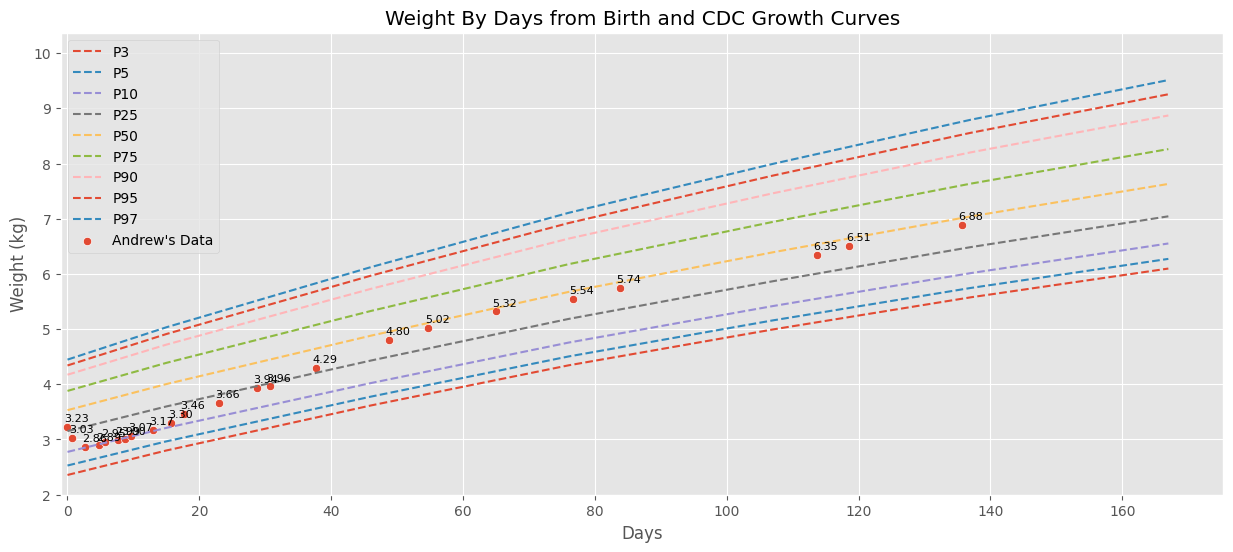

In [8]:
# CDC Data
SEX = 1 # 1 for male 2 for female

cdc_df = (pd.read_csv(files_dict['wtageinf'])
          .drop(columns=['L','M','S'])
          .assign(Days = lambda x: (x['Agemos']*365.25/12.0).apply(np.round).astype(int)))
cdc_df = cdc_df[cdc_df.Sex == SEX].drop(columns=['Sex','Agemos']).set_index('Days')
next_cdc_idx = list(filter(lambda x: x>int(growth_df.days.max() + 10),list(cdc_df.index)))[0]

# plot data
ax = cdc_df.loc[:next_cdc_idx].plot(figsize=(15,6),linestyle='dashed')
ax = sns.scatterplot(data=growth_df,x='days',y='Weight (lbs.)',label='Andrew\'s Data',ax=ax)

ax.set_title('Weight By Days from Birth and CDC Growth Curves')

# add point labels
yl = ax.get_ylim()
xl = ax.get_xlim()
ax.set_xlim(-1,xl[1])
ax.set_ylim(yl[0],yl[1]+0.5)
for x, y in zip(growth_df.days, growth_df['Weight (lbs.)'].values):
    ax.text(x-0.5, y+0.1, f"{y:0.2f}", fontsize=8)
ax.set_ylabel('Weight (kg)')
ax.legend(loc='upper left')
_=plt.savefig(os.path.join(figure_path,'weight.png'),bbox_inches='tight')

## Feeding Habits

,Formula (oz.),Milk (oz.),Amount (oz.),Time Between Feeds (min)
count,50.000000,0.0,50.000000,50.000000
mean,4.246000,NaN,4.246000,202.940000
std,1.671241,NaN,1.671241,158.325344
min,1.000000,NaN,1.000000,35.000000
25%,3.000000,NaN,3.000000,119.500000
50%,4.000000,NaN,4.000000,157.500000
75%,5.850000,NaN,5.850000,198.000000
max,8.000000,NaN,8.000000,670.000000


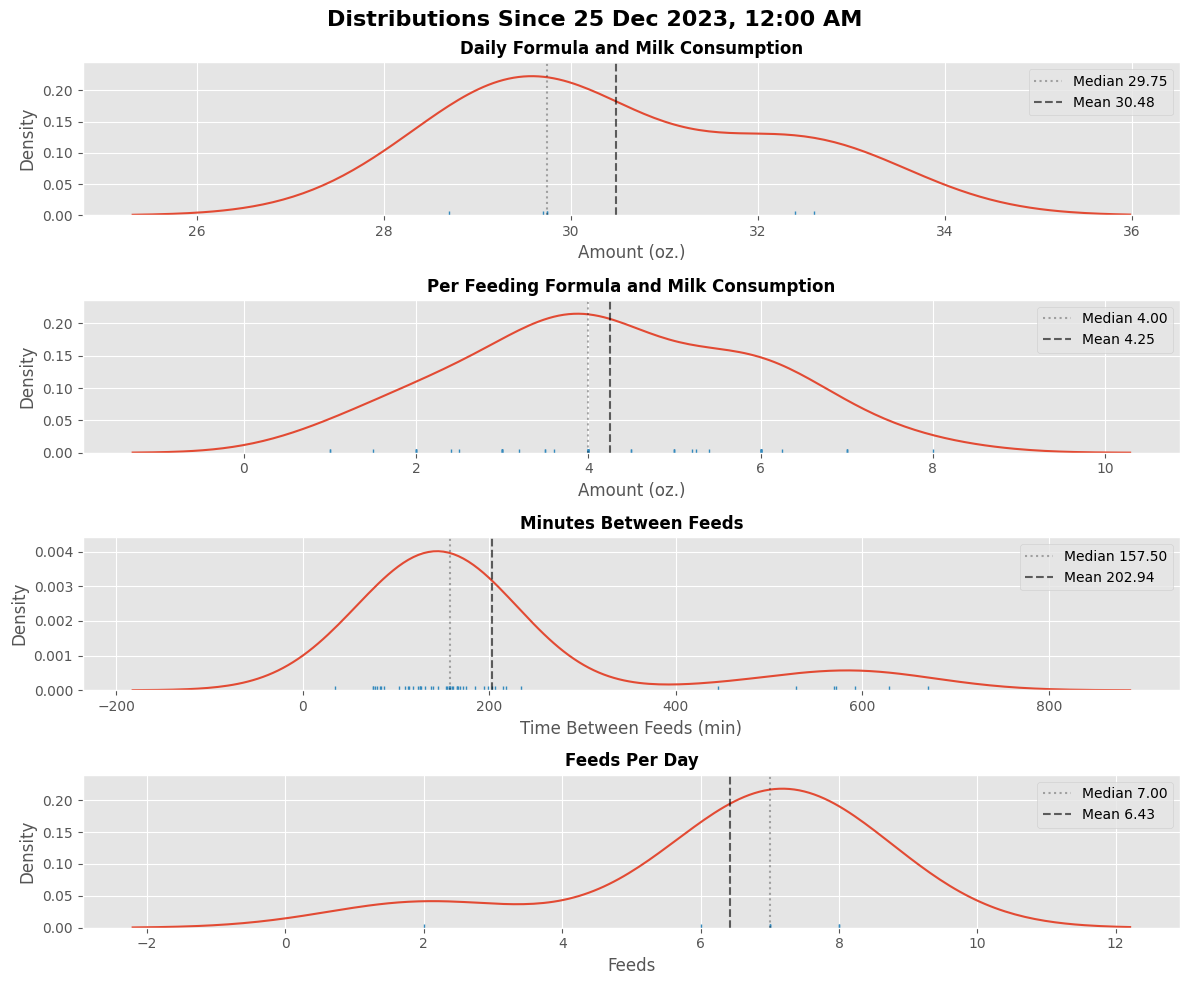

In [9]:
feeding_df = (pd.concat((get_data(files_dict['Andrew_formula']).rename(columns={'Amount (oz.)':'Formula (oz.)'}),
                        get_data(files_dict['Andrew_expressed']).rename(columns={'Amount (oz.)':'Milk (oz.)'})),axis=1)
                        .drop(columns=['Note'])
                        .assign(Amount = lambda x: x['Formula (oz.)'].fillna(x['Milk (oz.)']))
                        .rename(columns={'Amount':'Amount (oz.)'})
                        .sort_index())
start_date, analysis_flt = get_recent_filter(feeding_df)
feeding_df['hour_of_day'] = [x.hour for x in feeding_df.index]
feeding_df['Time Between Feeds (min)'] = feeding_df.index
feeding_df['Time Between Feeds (min)'] = feeding_df['Time Between Feeds (min)'].diff().fillna(timedelta(seconds=0))
feeding_df['Time Between Feeds (min)'] = feeding_df['Time Between Feeds (min)'].apply(lambda x: x.seconds//60)
feeding_df['Feeds'] = 0
feeding_df['Feeds'].loc[~feeding_df['Amount (oz.)'].isna()] = 1
tdf = feeding_df.resample('D').sum()[['Amount (oz.)']]
ts,tf = get_recent_filter(tdf)
tdf = tdf.loc[tf & (tdf.index<today)]

# analyze recent data
feeding_df['rolling mean amount'] = feeding_df['Amount (oz.)'].rolling(to_analyze).mean()
feeding_df['rolling median amount'] = feeding_df['Amount (oz.)'].rolling(to_analyze).median()

feeding_df['rolling mean time between feeds'] = feeding_df['Time Between Feeds (min)'].rolling(to_analyze).mean()
feeding_df['rolling median time between feeds'] = feeding_df['Time Between Feeds (min)'].rolling(to_analyze).median()

stats = feeding_df.loc[analysis_flt].describe()
display(stats[['Formula (oz.)','Milk (oz.)','Amount (oz.)','Time Between Feeds (min)']])
mean = stats.at['mean','Amount (oz.)']
median = stats.at['50%','Amount (oz.)']
mean_time = stats.at['mean','Time Between Feeds (min)']
median_time = stats.at['50%','Time Between Feeds (min)']
mean_total = tdf.describe().at['mean','Amount (oz.)']
median_total = tdf.describe().at['50%','Amount (oz.)']

# plot
f,axes = plt.subplots(ncols=1,nrows=4,figsize=(12,10))
ax0,ax1,ax2,ax3 = axes.ravel()
ax=sns.kdeplot(data=tdf,x='Amount (oz.)',ax=ax0)
ax=sns.rugplot(data=tdf,x='Amount (oz.)',ax=ax)
ax.axvline(median_total,color='k',linestyle='dotted',label=f'Median {median_total:0.2f}',alpha=0.3)
ax.axvline(mean_total,color='k',linestyle='dashed',label=f'Mean {mean_total:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Daily Formula and Milk Consumption',fontweight='bold',fontsize=12)

ax=sns.kdeplot(data=feeding_df.loc[analysis_flt],x='Amount (oz.)',ax=ax1)
ax=sns.rugplot(data=feeding_df.loc[analysis_flt],x='Amount (oz.)',ax=ax)
ax.axvline(median,color='k',linestyle='dotted',label=f'Median {median:0.2f}',alpha=0.3)
ax.axvline(mean,color='k',linestyle='dashed',label=f'Mean {mean:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Per Feeding Formula and Milk Consumption',fontweight='bold',fontsize=12)

ax=sns.kdeplot(data=feeding_df.loc[analysis_flt],x='Time Between Feeds (min)',ax=ax2)
ax=sns.rugplot(data=feeding_df.loc[analysis_flt],x='Time Between Feeds (min)',ax=ax)
ax.axvline(median_time,color='k',linestyle='dotted',label=f'Median {median_time:0.2f}',alpha=0.3)
ax.axvline(mean_time,color='k',linestyle='dashed',label=f'Mean {mean_time:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Minutes Between Feeds',fontweight='bold',fontsize=12)


daily_feeds_df = feeding_df.resample('D').sum()
daily_feeds_df['rolling mean feeds per day'] = daily_feeds_df['Feeds'].rolling(to_analyze).mean()
daily_feeds_df['rolling median feeds per day'] = daily_feeds_df['Feeds'].rolling(to_analyze).median()
start_date,analysis_flt = get_recent_filter(daily_feeds_df)
mean_feeds = daily_feeds_df.loc[analysis_flt].Feeds.mean()
median_feeds = daily_feeds_df.loc[analysis_flt].Feeds.median()
ax=sns.kdeplot(data=daily_feeds_df.loc[analysis_flt],x='Feeds',ax=ax3)
ax=sns.rugplot(data=daily_feeds_df.loc[analysis_flt],x='Feeds',ax=ax)
ax.axvline(median_feeds,color='k',linestyle='dotted',label=f'Median {median_feeds:0.2f}',alpha=0.3)
ax.axvline(mean_feeds,color='k',linestyle='dashed',label=f'Mean {mean_feeds:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Feeds Per Day',fontweight='bold',fontsize=12)

plt.suptitle(f'Distributions Since {s}',fontweight='bold',fontsize=16)
plt.tight_layout()

_=plt.savefig(os.path.join(figure_path,'feeding_distribution.png'),bbox_inches='tight')

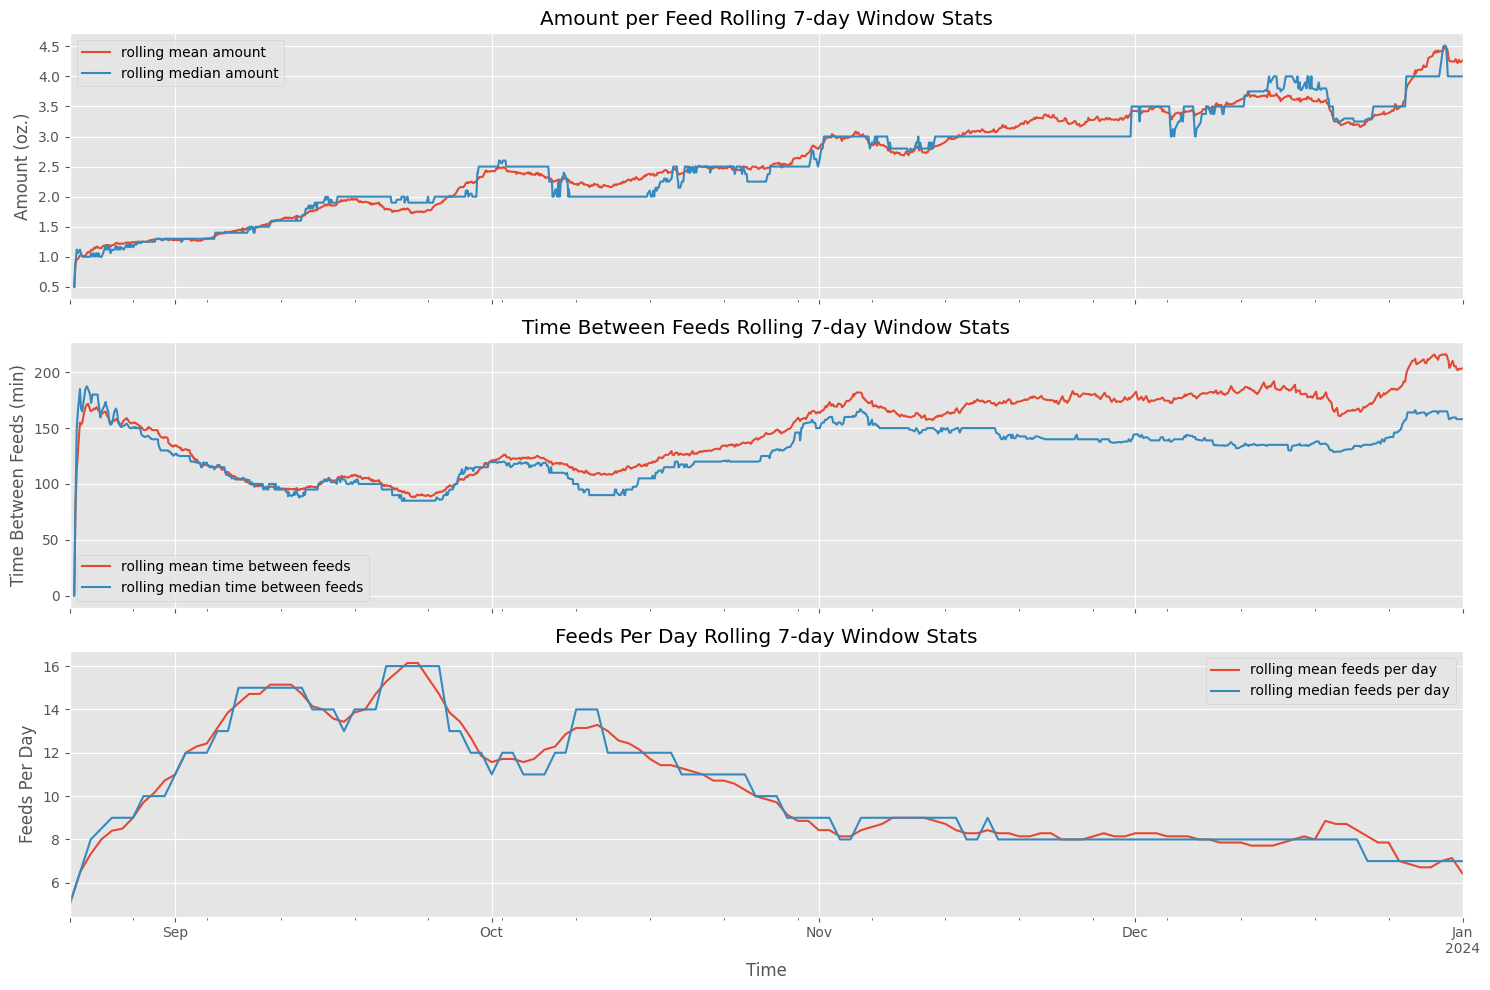

In [10]:
f,axes = plt.subplots(ncols=1,nrows=3,figsize=(15,10),sharex=True)
ax1,ax2,ax3 = axes.ravel()
ax = feeding_df[['rolling mean amount','rolling median amount']].dropna().plot(ax=ax1)
ax.set_ylabel('Amount (oz.)')
ax.set_title(f'Amount per Feed Rolling {to_analyze.days}-day Window Stats')

ax = feeding_df[['rolling mean time between feeds','rolling median time between feeds']].dropna().plot(ax=ax2)
ax.set_ylabel('Time Between Feeds (min)')
ax.set_title(f'Time Between Feeds Rolling {to_analyze.days}-day Window Stats')

ax = daily_feeds_df[['rolling mean feeds per day','rolling median feeds per day']].dropna().plot(ax=ax3)
#ax.axhline(11,label='Scheduled Target',linestyle='dotted',color='k',alpha=0.5)
ax.set_ylabel('Feeds Per Day')
ax.set_title(f'Feeds Per Day Rolling {to_analyze.days}-day Window Stats')
plt.tight_layout()
_=plt.savefig(os.path.join(figure_path,'feeding_rolling.png'),bbox_inches='tight')

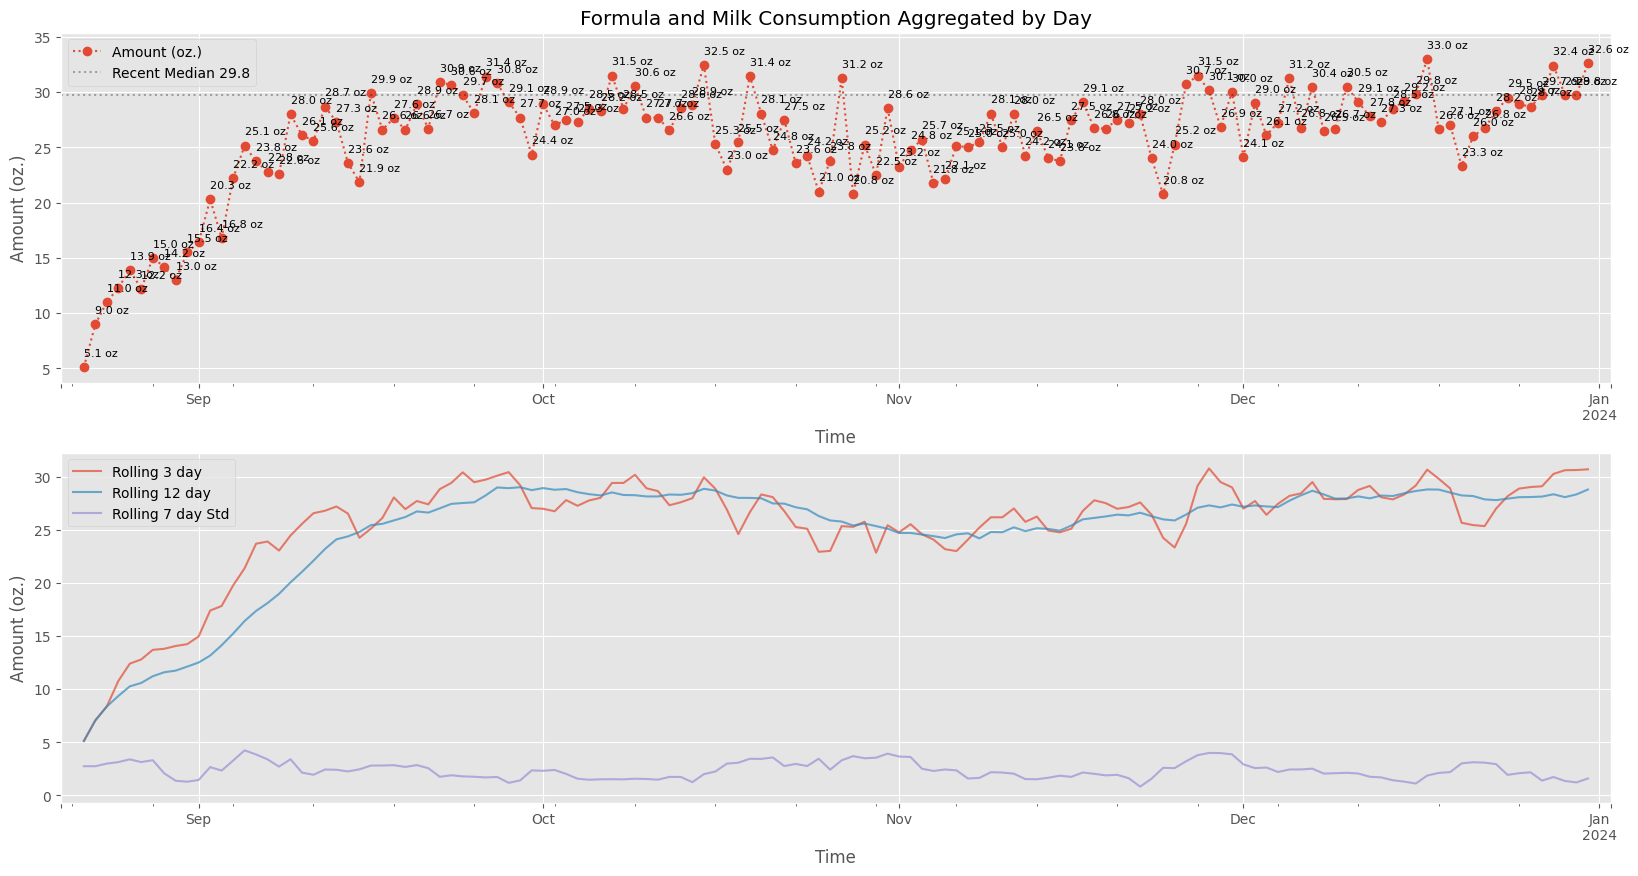

In [11]:
tdf = feeding_df.resample('D').sum()[['Amount (oz.)']]
tdf['Rolling 3 day'] = tdf['Amount (oz.)'].rolling('3D').mean()
tdf['Rolling 12 day'] = tdf['Amount (oz.)'].rolling('12D').mean()
tdf['Rolling 7 day Std'] = tdf['Amount (oz.)'].rolling('7D').std()
tdf = pd.DataFrame(tdf.loc[tdf.index<today]) # drop incomplete day
tdf['x'] = range(1,len(tdf.index)+1)
f,axes = plt.subplots(nrows=2,ncols=1,figsize=(20,10))
axes = axes.ravel()
ax = tdf['Amount (oz.)'].plot(marker='o',linestyle='dotted',ax=axes[0])
ax.set_xlim(tdf.index[0]-timedelta(days=2),tdf.index[-1]+timedelta(days=2))
x1 = ax.get_xlim()
yl = ax.get_ylim()
offset = 1.0
ax.set_ylim(yl[0],yl[1]+offset)
for x, y in zip(tdf.index, tdf['Amount (oz.)'].values):
    ax.text(x, y+offset, f"{y:0.1f} oz", fontsize=8)
ax.axhline(median_total,label=f'Recent Median {median_total:0.1f}',linestyle='dotted',color='k',alpha=0.3)
ax.set_ylabel('Amount (oz.)')
ax.legend(loc='upper left')
ax.set_title('Formula and Milk Consumption Aggregated by Day')
ax = tdf[['Rolling 3 day','Rolling 12 day','Rolling 7 day Std']].fillna(method='backfill').plot(ax=axes[1],alpha=0.7)
ax.set_xlim(*x1)
ax.set_ylabel('Amount (oz.)')
plt.tight_layout
_=plt.savefig(os.path.join(figure_path,'feeding_daily_totals.png'),bbox_inches='tight')

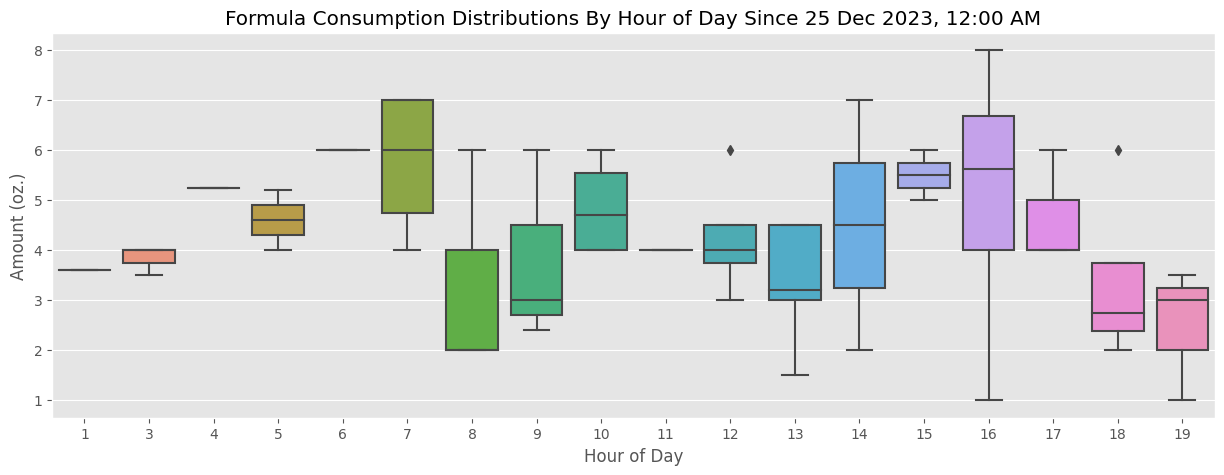

In [12]:
start_date,analysis_flt = get_recent_filter(feeding_df)
ax=sns.boxplot(data=feeding_df.loc[analysis_flt],y='Amount (oz.)',x='hour_of_day')
ax.set_title(f'Formula Consumption Distributions By Hour of Day Since {s}')
ax.set_xlabel('Hour of Day')
_=plt.savefig(os.path.join(figure_path,'feeding_by_hour.png'),bbox_inches='tight')

## Sleep

In [13]:
import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

def time_of_day(hour):
    if hour < 7 or hour > 18:
        return 'night'
    else:
        return 'day'
def clean_duration(x):
    if x > 14*60: #10 hours
        return np.nan
    else:
        return x

sleep_df = get_data(files_dict['Andrew_sleep'])
sleep_df['Duration (min)'] = sleep_df['Duration (min)'].apply(locale.atoi)
sleep_df['Duration (min)'] = sleep_df['Duration (min)'].apply(clean_duration)
sleep_df = sleep_df.loc[sleep_df['Duration (min)'].dropna().index]
sleep_df['Duration (min)'] = sleep_df['Duration (min)'].astype(int)
sleep_df['Time of Day'] = [time_of_day(x.hour) for x in sleep_df.index]
sleep_df[~sleep_df.Note.isna()]


,Duration (min),Note,Time of Day
Time,,,
2023-10-27 18:25:00,95,wifey beat son with wet noodle to wake him up,day
2023-10-27 20:35:00,180,woke himself,night
2023-10-28 00:17:00,138,Stirred in his sleep,night
2023-10-28 02:55:00,45,Woke himself crying,night
2023-11-02 18:26:00,97,I woke to feed,day
2023-11-05 16:20:00,220,Woke him to feed…he’s barely awake only 1oz,day
2023-11-06 16:55:00,72,Walks him to eat,day
2023-11-06 18:52:00,76,Woke him up for feed,day
2023-11-07 18:25:00,94,Woke up on his own crying,day


In [14]:
start_date, recent_filter = get_recent_filter(df=sleep_df)
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
print('Full History Stats')
display(sleep_df.groupby('Time of Day').describe())
print(f'Recent Stats Since {s}')
display(sleep_df.loc[recent_filter].groupby('Time of Day').describe())


Full History Stats


Duration (min)                                                  \
                     count        mean         std  min   25%   50%    75%   
Time of Day                                                                  
day                  373.0   48.067024   68.833470  1.0  23.0  33.0   46.0   
night                273.0  121.531136  131.729781  1.0  33.0  63.0  150.0   

                    
               max  
Time of Day         
day          499.0  
night        655.0

Recent Stats Since 25 Dec 2023, 07:39 AM


Duration (min)                                              \
                     count        mean         std   min    25%    50%   
Time of Day                                                              
day                   33.0   44.787879   67.777558   2.0  25.00   34.0   
night                 20.0  206.400000  209.185236  21.0  56.75  104.5   

                            
                75%    max  
Time of Day                 
day           40.00  413.0  
night        399.75  655.0

count    373.000000
mean      48.067024
std       68.833470
min        1.000000
25%       23.000000
50%       33.000000
75%       46.000000
max      499.000000
Name: Duration (min), dtype: float64

count    273.000000
mean     121.531136
std      131.729781
min        1.000000
25%       33.000000
50%       63.000000
75%      150.000000
max      655.000000
Name: Duration (min), dtype: float64

count     33.000000
mean      44.787879
std       67.777558
min        2.000000
25%       25.000000
50%       34.000000
75%       40.000000
max      413.000000
Name: Duration (min), dtype: float64

count     20.000000
mean     206.400000
std      209.185236
min       21.000000
25%       56.750000
50%      104.500000
75%      399.750000
max      655.000000
Name: Duration (min), dtype: float64

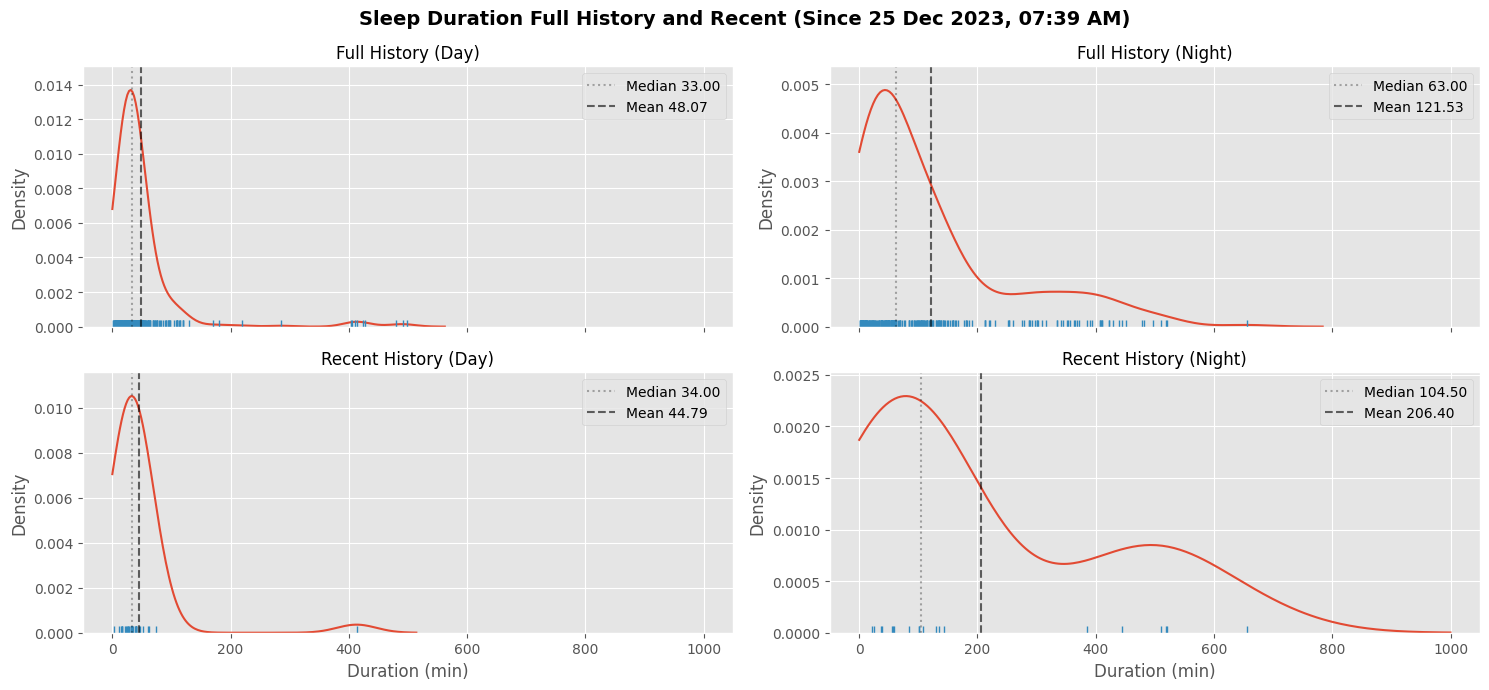

In [15]:
def plot_dist_with_mean_median(df,col,ax,title):
    display(df.describe()[col])
    mean,median = df.describe()[col].loc[['mean','50%']].values
    ax = sns.kdeplot(df[col],clip=(0,np.inf),ax=ax)
    ax = sns.rugplot(df[col],ax=ax)
    ax.axvline(median,color='k',linestyle='dotted',label=f'Median {median:0.2f}',alpha=0.3)
    ax.axvline(mean,color='k',linestyle='dashed',label=f'Mean {mean:0.2f}',alpha=0.6)
    ax.legend()
    ax.set_title(title,fontsize=12)
    return ax

f,axes = plt.subplots(nrows=2,ncols=2,figsize=(15,7),sharex=True)
axes = axes.ravel().reshape(-1,2)
plot_dist_with_mean_median(sleep_df[sleep_df['Time of Day'] == 'day'],
                           'Duration (min)',axes[0,0],'Full History (Day)')
plot_dist_with_mean_median(sleep_df[sleep_df['Time of Day'] == 'night'],
                           'Duration (min)',axes[0,1],'Full History (Night)')
plot_dist_with_mean_median(sleep_df[(sleep_df['Time of Day'] == 'day')&recent_filter],
                           'Duration (min)',axes[1,0],'Recent History (Day)')
plot_dist_with_mean_median(sleep_df[(sleep_df['Time of Day'] == 'night')&recent_filter],
                           'Duration (min)',axes[1,1],'Recent History (Night)')
plt.suptitle(f'Sleep Duration Full History and Recent (Since {s})',
             fontsize=14,fontweight='bold')
plt.tight_layout()
_=plt.savefig(os.path.join(figure_path,'sleep_duration_day_night.png'),bbox_inches='tight')